In [48]:
# %pip install seaborn
# %pip install datetime
import re
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


In [ ]:
mask = oilRaw['dcoilwtico;;'].str.contains('%')
oilExtra = oilRaw[mask].copy()
oil = oilRaw[~mask].copy()
oil.reset_index(drop=True, inplace=True)
oil['dcoilwtico;;'] = oil['dcoilwtico;;'].str.replace(';', '')
oil['dcoilwtico;;'] = oil['dcoilwtico;;'].apply(lambda x: x.strip())
oil = oil[~(oil['dcoilwtico;;'] == '')]

try:
    oil['dcoilwtico;;'] = oil['dcoilwtico;;'].astype(float).round(2)
except:
    oil.dropna(subset=['dcoilwtico;;'], inplace=True)

oil.rename(columns={'dcoilwtico;;': 'dcoilwtico'}, inplace=True)


In [ ]:
# Extending the provided sample to include all months up to "Dec 2017"
date_samples = [
    "jan/13", "feb/13", "Mar 2013", "apr/13", "May 2013", "jun/13",
    "jul/13", "aug/13", "sep/13", "Oct 2013", "nov/13", "dec/13",
    "jan/14", "feb/14", "Mar 2014", "apr/14", "May 2014", "jun/14",
    "jul/14", "aug/14", "sep/14", "Oct 2014", "nov/14", "dec/14",
    "jan/15", "feb/15", "Mar 2015", "apr/15", "May 2015", "jun/15",
    "jul/15", "aug/15", "sep/15", "Oct 2015", "nov/15", "dec/15",
    "jan/16", "feb/16", "Mar 2016", "apr/16", "May 2016", "jun/16",
    "jul/16", "aug/16", "sep/16", "Oct 2016", "nov/16", "dec/16",
    "jan/17", "feb/17", "Mar 2017", "apr/17", "May 2017", "jun/17",
    "jul/17", "aug/17", "sep/17", "Oct 2017", "nov/17", "dec/17",
    # Including the range "Jan 2013" to "Dec 2017"
    "Jan 2013", "Feb 2013", "Mar 2013", "Apr 2013", "May 2013", "Jun 2013",
    "Jul 2013", "Aug 2013", "Sep 2013", "Oct 2013", "Nov 2013", "Dec 2013",
    "Jan 2014", "Feb 2014", "Mar 2014", "Apr 2014", "May 2014", "Jun 2014",
    "Jul 2014", "Aug 2014", "Sep 2014", "Oct 2014", "Nov 2014", "Dec 2014",
    "Jan 2015", "Feb 2015", "Mar 2015", "Apr 2015", "May 2015", "Jun 2015",
    "Jul 2015", "Aug 2015", "Sep 2015", "Oct 2015", "Nov 2015", "Dec 2015",
    "Jan 2016", "Feb 2016", "Mar 2016", "Apr 2016", "May 2016", "Jun 2016",
    "Jul 2016", "Aug 2016", "Sep 2016", "Oct 2016", "Nov 2016", "Dec 2016",
    "Jan 2017", "Feb 2017", "Mar 2017", "Apr 2017", "May 2017", "Jun 2017",
    "Jul 2017", "Aug 2017", "Sep 2017", "Oct 2017", "Nov 2017", "Dec 2017"
]
# Define a function to convert date strings to 'YYYY-MM' format using regular expressions
def convert_date(date_str):
    # Define the regex pattern for matching the date strings
    # This pattern matches strings like "Jan/13", "jan/13", "Oct 2017", "oct 2017"
    pattern = r'(?i)(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[/ ](\d{2,4})'
    match = re.match(pattern, date_str)
    
    if match:
        month_str, year_str = match.groups()
        # Handle two-digit year
        if len(year_str) == 2:
            year_str = "20" + year_str  # Assuming all dates are in the 2000s
        
        # Convert the month string to a month number, ensuring it's case-insensitive
        month_num = datetime.strptime(month_str.title(), '%b').month
        # Format the date string as 'YYYY-MM'
        return f"{year_str}-{month_num:02d}"
    else:
        # If the date string doesn't match the pattern, return None or handle as needed
        return None

# Example usage on the sample dates
converted_dates_regex = [convert_date(date) for date in date_samples]

# Show the first few converted dates for verification
converted_dates_regex[:10]


# Applying the conversion function to the 'date' column
oilExtra['date'] = oilExtra['date'].apply(convert_date)

oilExtra.head()

vanaf hier gaan we de vragen oplossen en visualizeren

In [ ]:
# Aggregate transactions by store number to find the total sales (transactions) per store
total_sales_per_store = transactions.groupby('store_nbr')['transactions'].sum().reset_index()

# Find the store with the highest total sales
highest_sales_store = total_sales_per_store.loc[total_sales_per_store['transactions'].idxmax()]

highest_sales_store

# Sort the stores by sales in descending order for better visualization
total_sales_per_store_sorted = total_sales_per_store.sort_values('transactions', ascending=False)


In [ ]:
# Plotting
plt.figure(figsize=(14, 7))
plt.bar(total_sales_per_store_sorted['store_nbr'].astype(str), total_sales_per_store_sorted['transactions'])
plt.xlabel('Store Number')
plt.ylabel('Total Transactions')
plt.title('Total Transactions per Store')
plt.xticks(rotation=90)  # Rotate store number labels to avoid overlap
plt.tight_layout()

# Highlight the store with the highest sales
plt.axhline(y=highest_sales_store['transactions'], color='r', linestyle='--')
plt.annotate(f'Highest: Store {highest_sales_store["store_nbr"]}', 
             xy=(highest_sales_store["store_nbr"] - 1, highest_sales_store['transactions']),
             xytext=(highest_sales_store["store_nbr"] - 10, highest_sales_store['transactions'] + 100000),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

plt.show()

In [ ]:
# Merge data with items to link each sale to its item family
data_items_merged = pd.merge(data, items, on='item_nbr', how='left')

# Merge the result with stores to associate each sale with its store's location
data_items_stores_merged = pd.merge(data_items_merged, stores, on='store_nbr', how='left')

# Filter for sales in West-Bengal
west_bengal_sales = data_items_stores_merged[data_items_stores_merged['state'] == 'West Bengal']

# Aggregate sales by item family
sales_by_family = west_bengal_sales.groupby('family')['unit_sales'].sum().reset_index()

# Sort the aggregated sales to find the top-selling item family
top_selling_families = sales_by_family.sort_values(by='unit_sales', ascending=False)

# The top-selling family can be found at the top of this sorted DataFrame
top_selling_family = top_selling_families.iloc[0]

top_selling_family

In [ ]:
plt.figure(figsize=(12, 8))  # Sets the figure size
plt.bar(top_selling_families['family'], top_selling_families['unit_sales'], color='skyblue')  # Creates a bar plot
plt.title('Item Family Sales in West-Bengal')  # Title of the plot
plt.xlabel('Item Family')  # Label for the X-axis
plt.ylabel('Total Unit Sales')  # Label for the Y-axis
plt.xticks(rotation=45, ha='right')  # Rotates the X-axis labels for better readability
plt.tight_layout()  # Adjusts subplot params for the plot to fit into the figure area

# Highlighting the top-selling item family
plt.bar(top_selling_families.iloc[0]['family'], top_selling_families.iloc[0]['unit_sales'], color='gold', label='Top Selling Family')
plt.legend()  # Adds a legend to distinguish the top-selling family

plt.show()  # Displays the plot

In [55]:
""" # 'oil' contains oil prices with 'date' and 'oil_price' columns
merged_data = pd.merge(data, oil, on='date', how='left')

daily_sales = merged_data.groupby('date')['unit_sales'].sum().reset_index()

daily_data_combined = pd.merge(daily_sales, oil, on='date', how='left')

plt.scatter(daily_data_combined['oil_price'], daily_data_combined['unit_sales'])
plt.xlabel('Oil Price')
plt.ylabel('Total Daily Sales')
plt.title('Relationship Between Oil Price and Total Daily Sales')
plt.show()

correlation_coefficient = daily_data_combined['oil_price'].corr(daily_data_combined['unit_sales'])
print(f'Pearson correlation coefficient: {correlation_coefficient}') """

" # 'oil' contains oil prices with 'date' and 'oil_price' columns\nmerged_data = pd.merge(data, oil, on='date', how='left')\n\ndaily_sales = merged_data.groupby('date')['unit_sales'].sum().reset_index()\n\ndaily_data_combined = pd.merge(daily_sales, oil, on='date', how='left')\n\nplt.scatter(daily_data_combined['oil_price'], daily_data_combined['unit_sales'])\nplt.xlabel('Oil Price')\nplt.ylabel('Total Daily Sales')\nplt.title('Relationship Between Oil Price and Total Daily Sales')\nplt.show()\n\ncorrelation_coefficient = daily_data_combined['oil_price'].corr(daily_data_combined['unit_sales'])\nprint(f'Pearson correlation coefficient: {correlation_coefficient}') "

In [56]:
""" plt.figure(figsize=(10, 6))
plt.scatter(daily_data_combined['oil_price'], daily_data_combined['unit_sales'], alpha=0.5)
plt.title('Oil Price vs. Total Daily Sales')
plt.xlabel('Oil Price')
plt.ylabel('Total Daily Sales')
plt.grid(True)
plt.show()plt.figure(figsize=(10, 6))
plt.scatter(daily_data_combined['oil_price'], daily_data_combined['unit_sales'], alpha=0.5)
plt.title('Oil Price vs. Total Daily Sales')
plt.xlabel('Oil Price')
plt.ylabel('Total Daily Sales')
plt.grid(True)
plt.show() """

" plt.figure(figsize=(10, 6))\nplt.scatter(daily_data_combined['oil_price'], daily_data_combined['unit_sales'], alpha=0.5)\nplt.title('Oil Price vs. Total Daily Sales')\nplt.xlabel('Oil Price')\nplt.ylabel('Total Daily Sales')\nplt.grid(True)\nplt.show()plt.figure(figsize=(10, 6))\nplt.scatter(daily_data_combined['oil_price'], daily_data_combined['unit_sales'], alpha=0.5)\nplt.title('Oil Price vs. Total Daily Sales')\nplt.xlabel('Oil Price')\nplt.ylabel('Total Daily Sales')\nplt.grid(True)\nplt.show() "

C:\Users\Cursist\AppData\Local\Temp\ipykernel_11740\2798143020.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='transactions', data=average_transactions_by_day, palette='coolwarm')


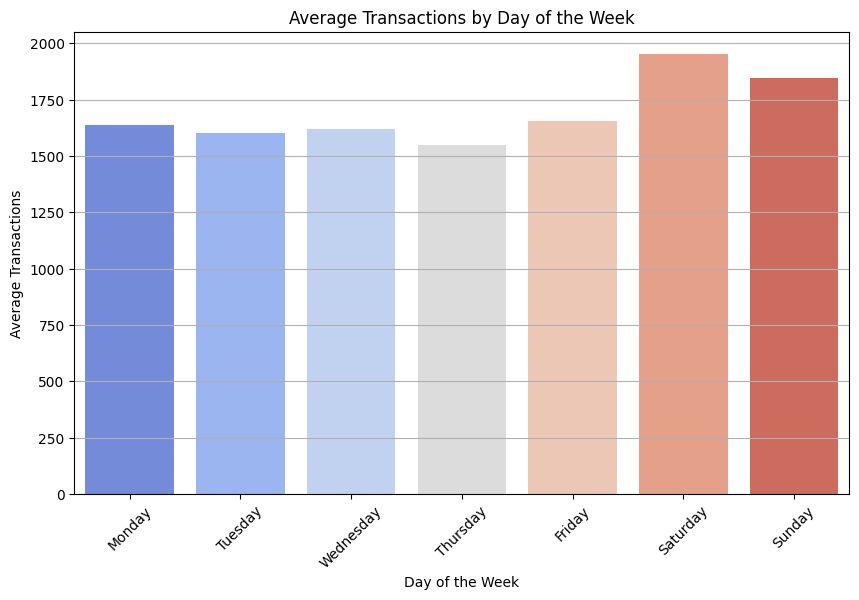

In [60]:
# Converting 'date' column to datetime format and extracting day of the week
#transactions['date'] = pd.to_datetime(transactions['date'])
transactions['day_of_week'] = transactions['date'].dt.day_name()

# Grouping the data by day of the week to calculate the average transactions
average_transactions_by_day = transactions.groupby('day_of_week')['transactions'].mean().reset_index()

# Ordering the days of the week for plotting
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
average_transactions_by_day['day_of_week'] = pd.Categorical(average_transactions_by_day['day_of_week'], categories=day_order, ordered=True)
average_transactions_by_day = average_transactions_by_day.sort_values('day_of_week')

# Plotting the average transactions by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='transactions', data=average_transactions_by_day, palette='coolwarm')
plt.title('Average Transactions by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Transactions')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2091618 entries, 0 to 2091617
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Unnamed: 0   int64         
 1   id           int64         
 2   date         datetime64[ns]
 3   store_nbr    int64         
 4   item_nbr     int64         
 5   unit_sales   float64       
 6   onpromotion  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 111.7+ MB
None
Empty DataFrame
Columns: [Unnamed: 0, id, date, store_nbr, item_nbr, unit_sales, onpromotion]
Index: []


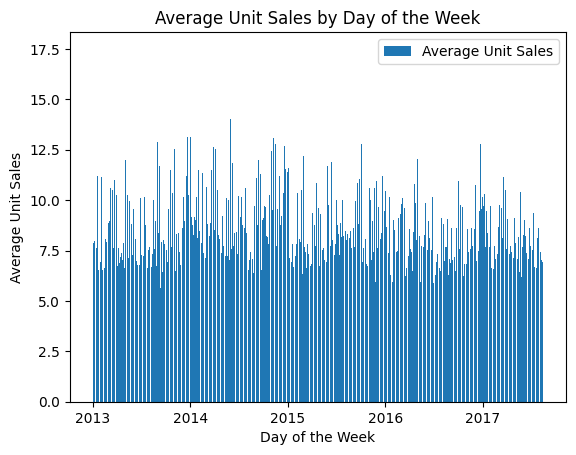

In [59]:
print(data.info())
# Calculate average unit sales by day of the week
average_sales_by_day = data.groupby('date').mean()['unit_sales']

# Subset of data where dates are in the holiday dataframe
holiday_sales_by_day = data[data['date'].isin(holidays_events['date'])]#.groupby('date').mean()['unit_sales']
print(holiday_sales_by_day)

# Create a bar chart
plt.bar(average_sales_by_day.index, average_sales_by_day, label='Average Unit Sales')
# plt.bar(holiday_sales_by_day.index, holiday_sales_by_day, label='Holiday Unit Sales')

# Add labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Average Unit Sales')
plt.title('Average Unit Sales by Day of the Week')

# Show the legend
plt.legend()

# Display the chart
plt.show()

In [ ]:
""" # Check if the DataFrame is not empty
if not top_selling_families.empty:
    plt.figure(figsize=(12, 8))  # Sets the figure size
    plt.bar(top_selling_families['family'], top_selling_families['unit_sales'], color='skyblue')  # Creates a bar plot
    plt.title('Item Family Sales in West-Bengal')  # Title of the plot
    plt.xlabel('Item Family')  # Label for the X-axis
    plt.ylabel('Total Unit Sales')  # Label for the Y-axis
    plt.xticks(rotation=45, ha='right')  # Rotates the X-axis labels for better readability
    plt.tight_layout()  # Adjusts subplot params so the plot fits into the figure area
    
    # Highlight the top-selling item family
    plt.bar(top_selling_families.iloc[0]['family'], top_selling_families.iloc[0]['unit_sales'], color='gold', label='Top Selling Family')
    plt.legend()  # Adds a legend to distinguish the top-selling family
    
    plt.show()  # Displays the plot
else:
    print("The quest yields no data! Check if 'West-Bengal' is correctly specified or if the data contains relevant entries.") """


In [61]:
# Which type of store is most present in your data? 
import plotly.express as px

store_types = stores['type'].value_counts()

fig = px.treemap(store_types, path=['type'], values='type', title='Store Types Distribution')
fig.show()


ValueError: Value of 'values' is not the name of a column in 'data_frame'. Expected one of ['count'] but received: type